# Lab 6
Prepared:
 - **Szymon Budziak**
 - **Krzysztof Gwiazda**

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from sklearn.metrics import RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.model_selection import cross_validate, KFold, GridSearchCV

In [2]:
columns = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "income"
]

categorical = [
    "workclass",
    "education",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "native-country",
    "income"
]

numerical = [
    "age",
    "fnlwgt",
    "education-num",
    "capital-gain",
    "capital-loss",
    "hours-per-week"
]

In [3]:
train = pd.read_csv("adult.data", names=columns, index_col=False)
test = pd.read_csv("adult.test", names=columns, index_col=False)

In [4]:
train_cat = train[categorical].replace("?", "unknown")
test_cat = test[categorical].replace("?", "unknown")

imputer = SimpleImputer(strategy="mean")
train_num = pd.DataFrame(imputer.fit_transform(train[numerical]), columns=numerical)
test_num = pd.DataFrame(imputer.transform(test[numerical]), columns=numerical)

train = pd.concat([train_cat, train_num], axis=1)
test = pd.concat([test_cat, test_num], axis=1)

In [5]:
X_train = train.drop(columns="income")
y_train = train["income"]

X_test = test.drop(columns="income")
y_test = test["income"]

X_train = pd.get_dummies(X_train, dtype=int)
X_test = pd.get_dummies(X_test, dtype=int)

X_train, X_test = X_train.align(X_test, join='inner', axis=1)

label_encoder = preprocessing.LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [6]:
def print_results(scores: dict) -> None:
    print(f'Balanced Accuracy: {np.mean(scores["test_balanced_accuracy"]):.3f} ({np.std(scores["test_balanced_accuracy"]):.3f})')
    print(f'Precision: {np.mean(scores["test_precision"]):.3f} ({np.std(scores["test_precision"]):.3f})')
    print(f'Recall: {np.mean(scores["test_recall"]):.3f} ({np.std(scores["test_recall"]):.3f})')

In [7]:
def display_plot(search: GridSearchCV, columns: list, title: str) -> None:
    values = search.best_estimator_.feature_importances_
    top_features = sorted(zip(values, columns), reverse=True)[:10]
    values, names = list(zip(*top_features))

    plt.figure(figsize=(14, 8))

    plt.bar(names, values, width=0.4)

    plt.xlabel("Feature name")
    plt.ylabel("Importance")

    plt.title(title)
    plt.show()

## 1. Decision Tree Classifier

In [8]:
cv_inner = KFold(n_splits=3,
                 shuffle=True,
                 random_state=100)

model = DecisionTreeClassifier()

grid = {
    'max_leaf_nodes': [2, 5, 10, 50, 100],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 5, 10]
}

search = GridSearchCV(model, grid, scoring='accuracy', n_jobs=1, cv=cv_inner, refit=True)

cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)

scores = cross_validate(search, X_train, y_train, scoring=['balanced_accuracy', 'precision', 'recall'],
                        cv=cv_outer, n_jobs=-1)

print_results(scores)

Balanced Accuracy: 0.734 (0.017)
Precision: 0.734 (0.025)
Recall: 0.529 (0.036)


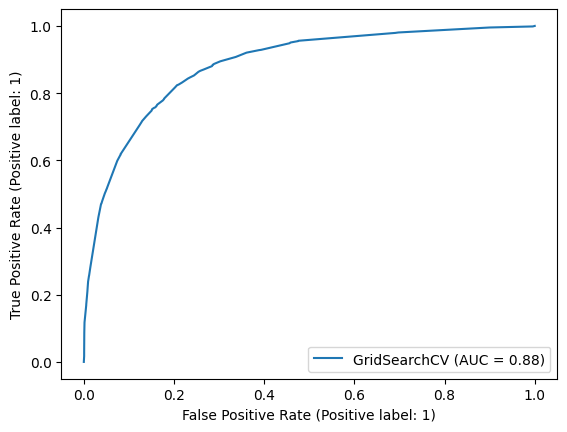

In [9]:
search.fit(X_train, y_train)

RocCurveDisplay.from_estimator(search, X_test, y_test)

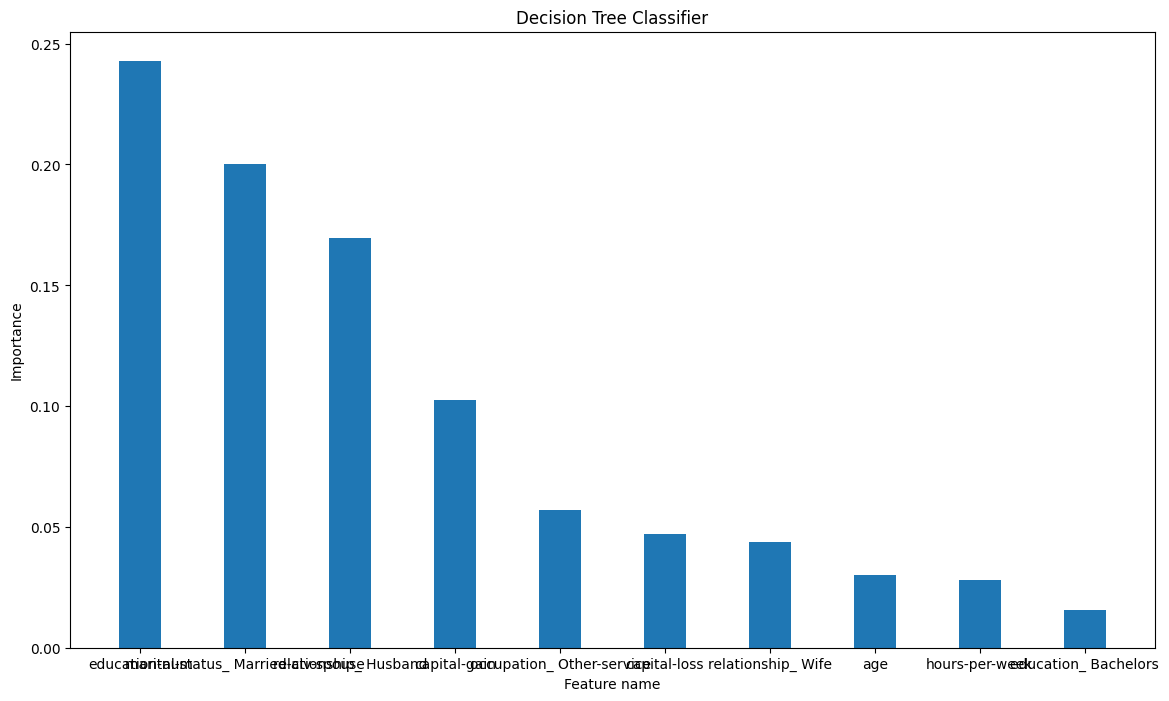

In [10]:
display_plot(search, X_train.columns, "Decision Tree Classifier")

## 2. Random Forest

In [11]:
cv_inner = KFold(n_splits=3,
                 shuffle=True,
                 random_state=100)

model = RandomForestClassifier()

grid = {
    'n_estimators': [50, 100, 250, 500],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 5, 10]
}

search = GridSearchCV(model, grid, scoring='accuracy', n_jobs=1, cv=cv_inner, refit=True)

cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)

scores = cross_validate(search, X_train, y_train, scoring=['balanced_accuracy', 'precision', 'recall'],
                        cv=cv_outer, n_jobs=-1)

print_results(scores)

Balanced Accuracy: 0.775 (0.004)
Precision: 0.779 (0.016)
Recall: 0.603 (0.009)


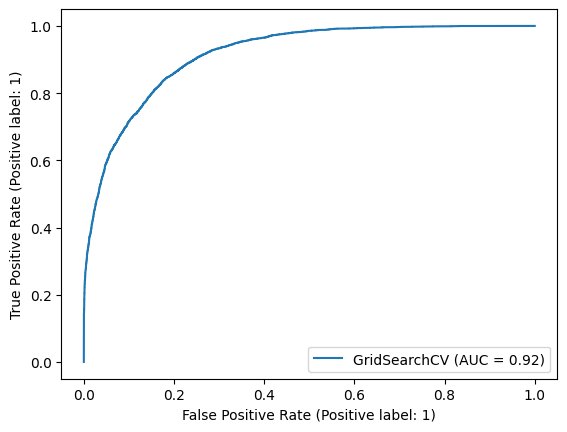

In [12]:
search.fit(X_train, y_train)

RocCurveDisplay.from_estimator(search, X_test, y_test)

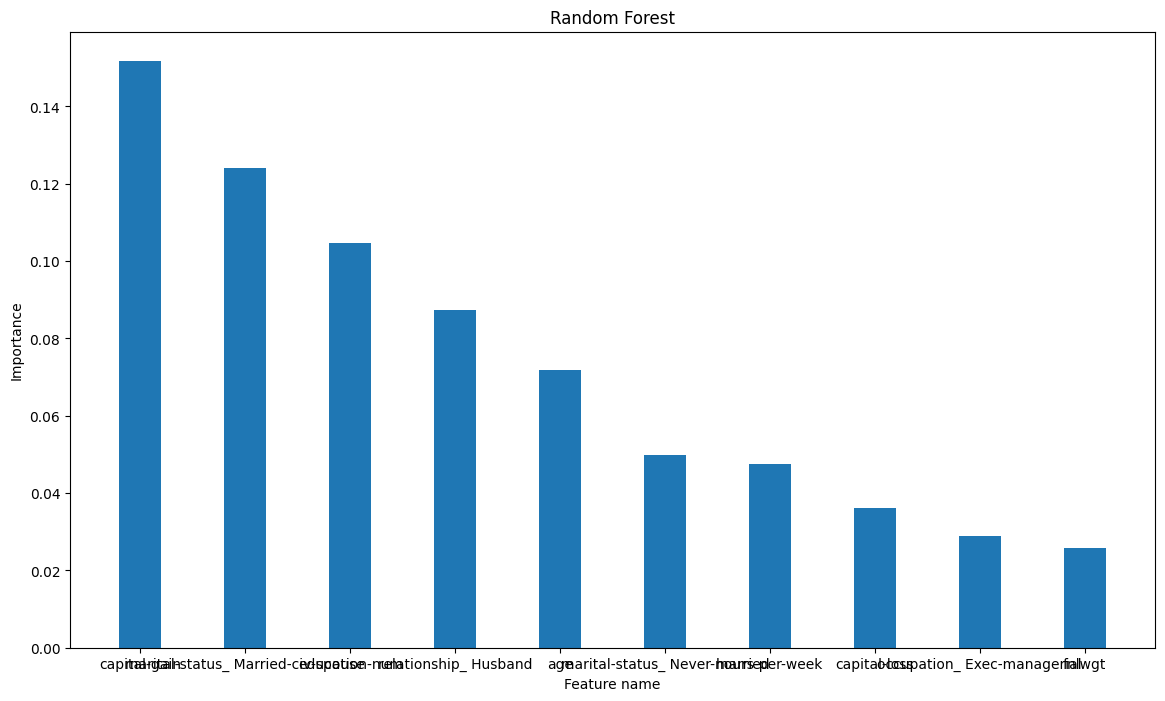

In [13]:
display_plot(search, X_train.columns, "Random Forest")

## 3. Extra trees

In [14]:
cv_inner = KFold(n_splits=3,
                 shuffle=True,
                 random_state=100)

model = ExtraTreesClassifier()

grid = {
    'n_estimators': [50, 100, 250, 500],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 5, 10]
}

search = GridSearchCV(model, grid, scoring='accuracy', n_jobs=1, cv=cv_inner, refit=True)

cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)

scores = cross_validate(search, X_train, y_train, scoring=['balanced_accuracy', 'precision', 'recall'],
                        cv=cv_outer, n_jobs=-1)

print_results(scores)

Balanced Accuracy: 0.748 (0.012)
Precision: 0.723 (0.021)
Recall: 0.564 (0.028)


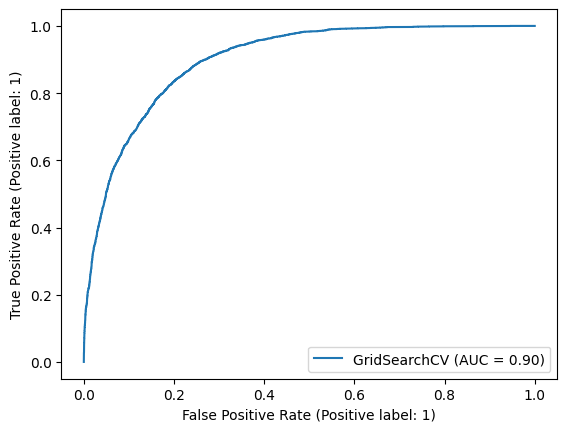

In [15]:
search.fit(X_train, y_train)

RocCurveDisplay.from_estimator(search, X_test, y_test)

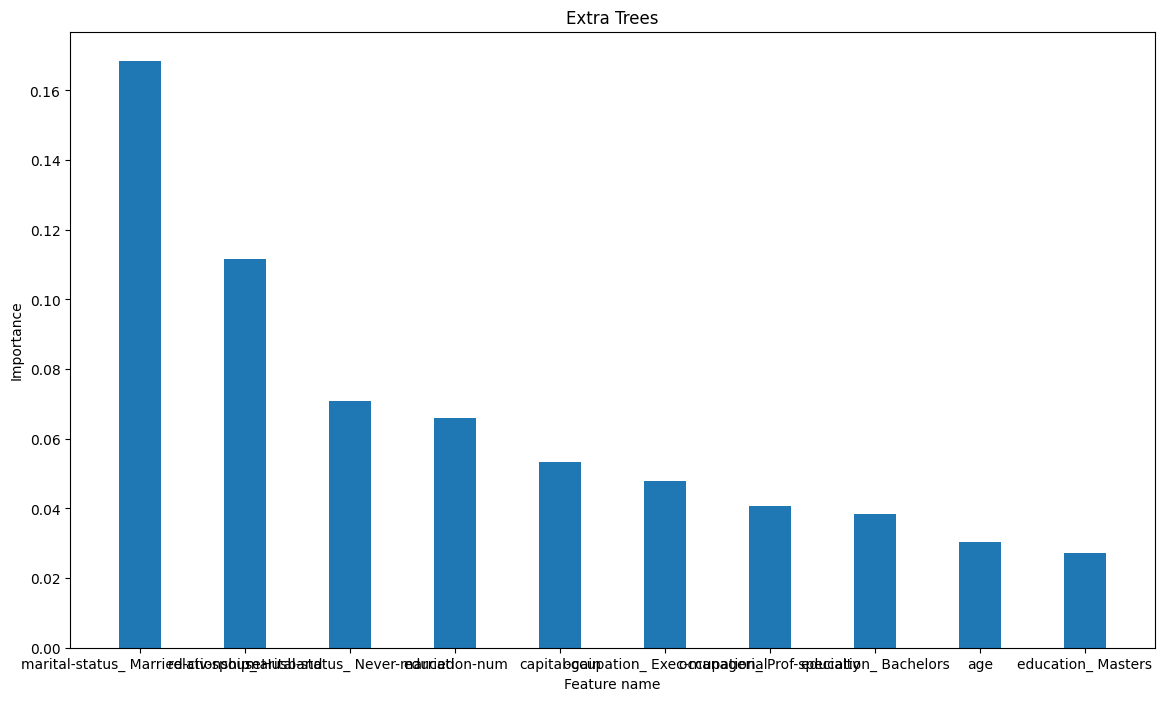

In [16]:
display_plot(search, X_train.columns, "Extra Trees")

## 4. Conclusion

1. Porównanie jakości klasyfikatorów

Dzięki zastosowaniu zagnieżdżonej walidacji skrośnej jesteśmy w stanie porównać wyniki trzech modeli z większą pewnością że nie wpływa na nie nadmierne przystosowanie do zbioru treningowego. Możemy patrzeć również na wyniki jakie osiągały modele przy trenowaniu na danych z całego zbioru treningowego przy walidacji na osobnym zbiorze testowym.

Ostatecznie po dostosowaniu parametrów wszystkie modele osiągnęły podobne rezultaty. Na zbiorze walidacyjnym było to AUC ~= 0.90. Wyniki przy zagnieżdżonej kros-walidacji były we wszystkich przypadkach znacznie niższe niż wyniki na zbiorze walidacyjnym. Adjusted accuracy ~ 0.77 podobne wartości precision i wysoki recall.



2. Czy lasy losowe były czułe na hiperparametry?

O ile nie były ustawiane na skrajne wartości jak np max_depth=2 przy Decision Tree Classifier to miały niewielki wpływ na wyniki w porównaniu do innych modeli.

3. Czy skuteczność oszacowana na etapie walidacji była zgodna ze skutecznością ustaloną na etapie
testowania?

W powyższych przypadkach była zazwyczaj wyższa nią na etapie testowania. Może to wynikać z uczenia na całym zbiorze treningowym a nie na jego części

4. Czy istnieje wyraźne powiązanie między użytymi cechami, a wynikiem predykcji?

Ograniczenie liczy cech wprowadzone w ramach grid search pomogło zwiększyć dokładność modelu 

5. Czy łatwo ocenić jakość klasyfikatora?

W przypadku klasyfikatorów interesuje nas najczęściej jaki jest stosunek wyników true positive do false positive które można odczytać z krzywej ROC. To czy model nie jest przetrenowany możemy sprawdzić stosując walidację skrośną.

6. Co sprawiło największy problem? 

Największy problem sprawiło znalezienie odpowiednich wartości jakie mogą dać dobre wyniki podczas optymalizacji hiperparametrów i zrozumienie jak można wykorzystać zagnieżdżoną walidację skrośną